# Assessment 02

Eurico Martins (nº. 8794, a8794@alunos.ipca.pt)
Gutelvam Fernandes (nº. 33791,  a33791@alunos.ipca.pt)

In [25]:
%pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [26]:
from time import time
import logging

import pandas as pd
import matplotlib.pyplot as plt
import squarify

import seaborn as sns

## Exploratory Data Analysis (EDA)

In [14]:
def load_data_and_inspect(csv_path:str) -> pd.DataFrame:
	logging.info(f"Loading data from ({csv_path})\n")

	df = pd.read_csv(csv_path)
	
	# Check the shape of the dataset (number of rows and columns)
	logging.info(f"-- Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
	
	# Get general info about the dataset, including data types and non-null counts
	logging.info(f"\nDataset Info\n {df.info()}\n")
	
	# Check for missing values
	logging.info(f"Missing values in dataset\n {df.isnull().sum()}\n")

	# Display the first 5 rows of the dataset
	logging.info(f"Head data:\n{df.head()}\n")

	# Describe the numeric columns for basic statistics
	logging.info(f"Descriptive Statistics\n{df.describe()}\n")

	return df

In [15]:
def get_numerical_categorical(sleep_df : pd.DataFrame):
	# List of numerical columns
	numerical_cols = sleep_df.select_dtypes(include=['int64', 'float64']).columns

	# List of categorical columns
	categorical_cols = sleep_df.select_dtypes(include=['object']).columns

	print("Numerical Columns:", numerical_cols)
	print("Categorical Columns:", categorical_cols)

	return numerical_cols, categorical_cols

In [33]:
def sleep_data_univariate(sleep_df : pd.DataFrame, num_cols, cat_cols):
	for col in num_cols:
		plt.figure(figsize=(6, 4))
		sns.histplot(sleep_df[col], kde=True, bins=30)
		plt.title(f'Distribution of {col}')
		plt.show()

	for col in cat_cols:
		plt.figure(figsize=(12, 8))
		
		value_counts = sleep_df[col].value_counts().nlargest(10)
		squarify.plot(sizes=value_counts.values, label=value_counts.index, alpha=0.8)
		
		plt.title(f'Treemap of {col}')
		plt.axis('off')
		plt.show()

In [31]:
def sleep_bivariate(sleep_df : pd.DataFrame, num_cols, cat_cols):
	sns.pairplot(sleep_df[num_cols])
	plt.show()

	for col in cat_cols:
		for num_col in num_cols:
				plt.figure(figsize=(8, 5))
				sns.boxplot(data=sleep_df, x=col, y=num_col)
				plt.title(f'{num_col} vs {col}')
				plt.xticks(rotation=45)
				plt.show()

# Main

INFO:root:Loading data from (../data/learning/sleep_time_prediction/sleeptime_prediction_dataset.csv)

INFO:root:-- Dataset Shape: 2000 rows, 7 columns

INFO:root:
Dataset Info
 None

INFO:root:Missing values in dataset
 WorkoutTime       0
ReadingTime       0
PhoneTime         0
WorkHours         0
CaffeineIntake    0
RelaxationTime    0
SleepTime         0
dtype: int64

INFO:root:Head data:
   WorkoutTime  ReadingTime  PhoneTime  WorkHours  CaffeineIntake  \
0         1.12         0.52       3.29       7.89          216.08   
1         2.85         0.49       4.22       5.03          206.18   
2         2.20         1.81       4.04       9.23           28.73   
3         1.80         0.50       1.62       7.68          276.77   
4         0.47         0.54       1.60       4.94          170.54   

   RelaxationTime SleepTime  
0            0.75      3.45  
1            0.67      4.88  
2            0.35      3.61  
3            1.21      4.94  
4            0.95       5.5  

INFO:roo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   WorkoutTime     2000 non-null   float64
 1   ReadingTime     2000 non-null   float64
 2   PhoneTime       2000 non-null   float64
 3   WorkHours       2000 non-null   float64
 4   CaffeineIntake  2000 non-null   float64
 5   RelaxationTime  2000 non-null   float64
 6   SleepTime       2000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 109.5+ KB
Numerical Columns: Index(['WorkoutTime', 'ReadingTime', 'PhoneTime', 'WorkHours',
       'CaffeineIntake', 'RelaxationTime'],
      dtype='object')
Categorical Columns: Index(['SleepTime'], dtype='object')


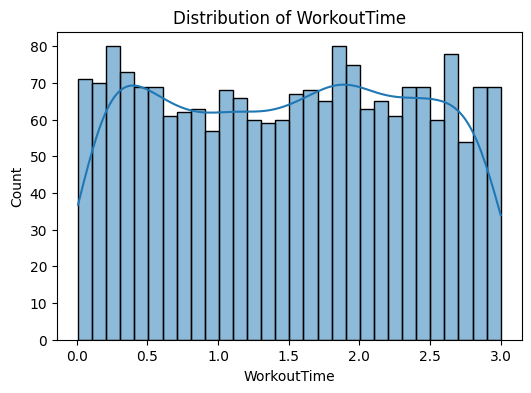

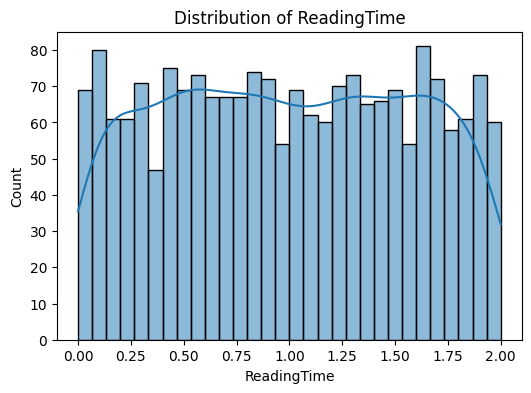

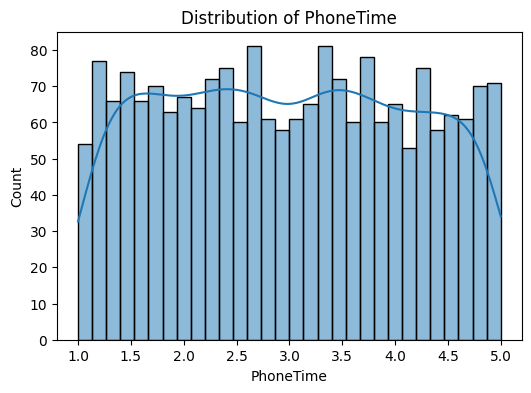

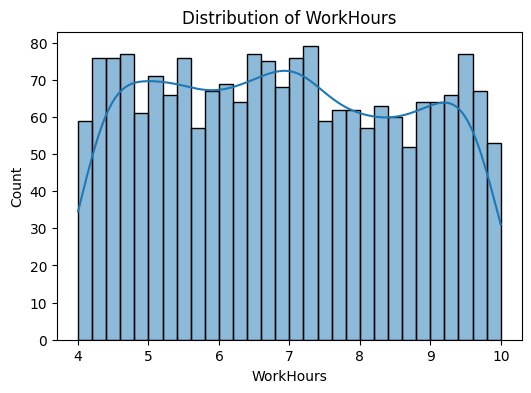

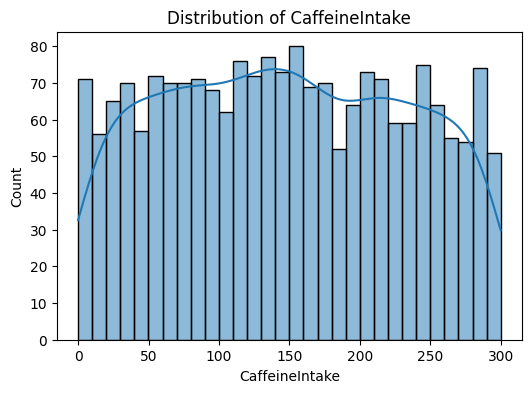

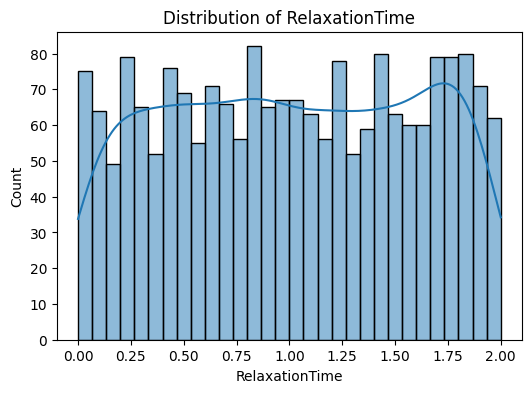

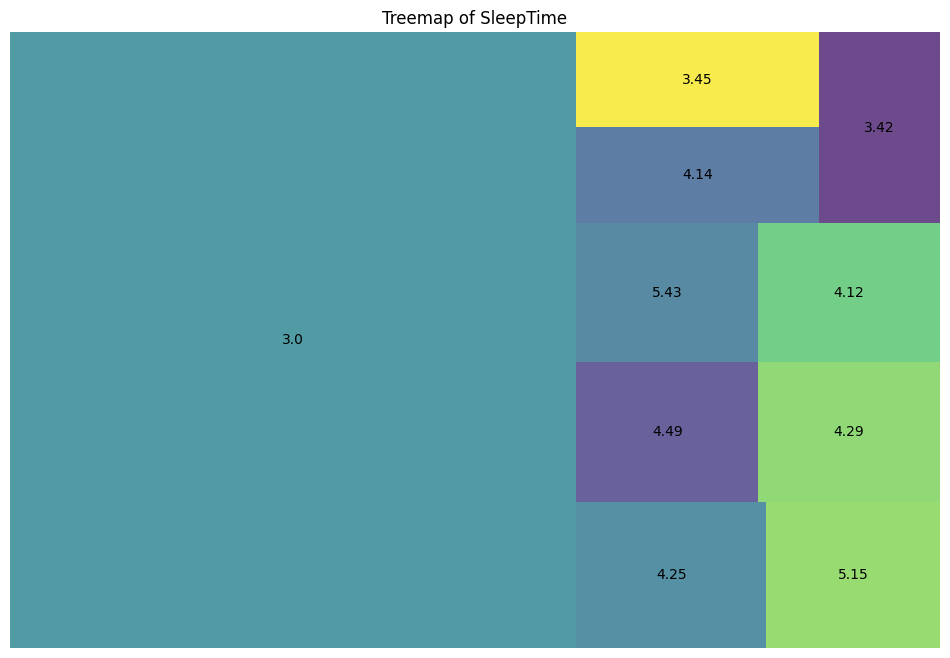

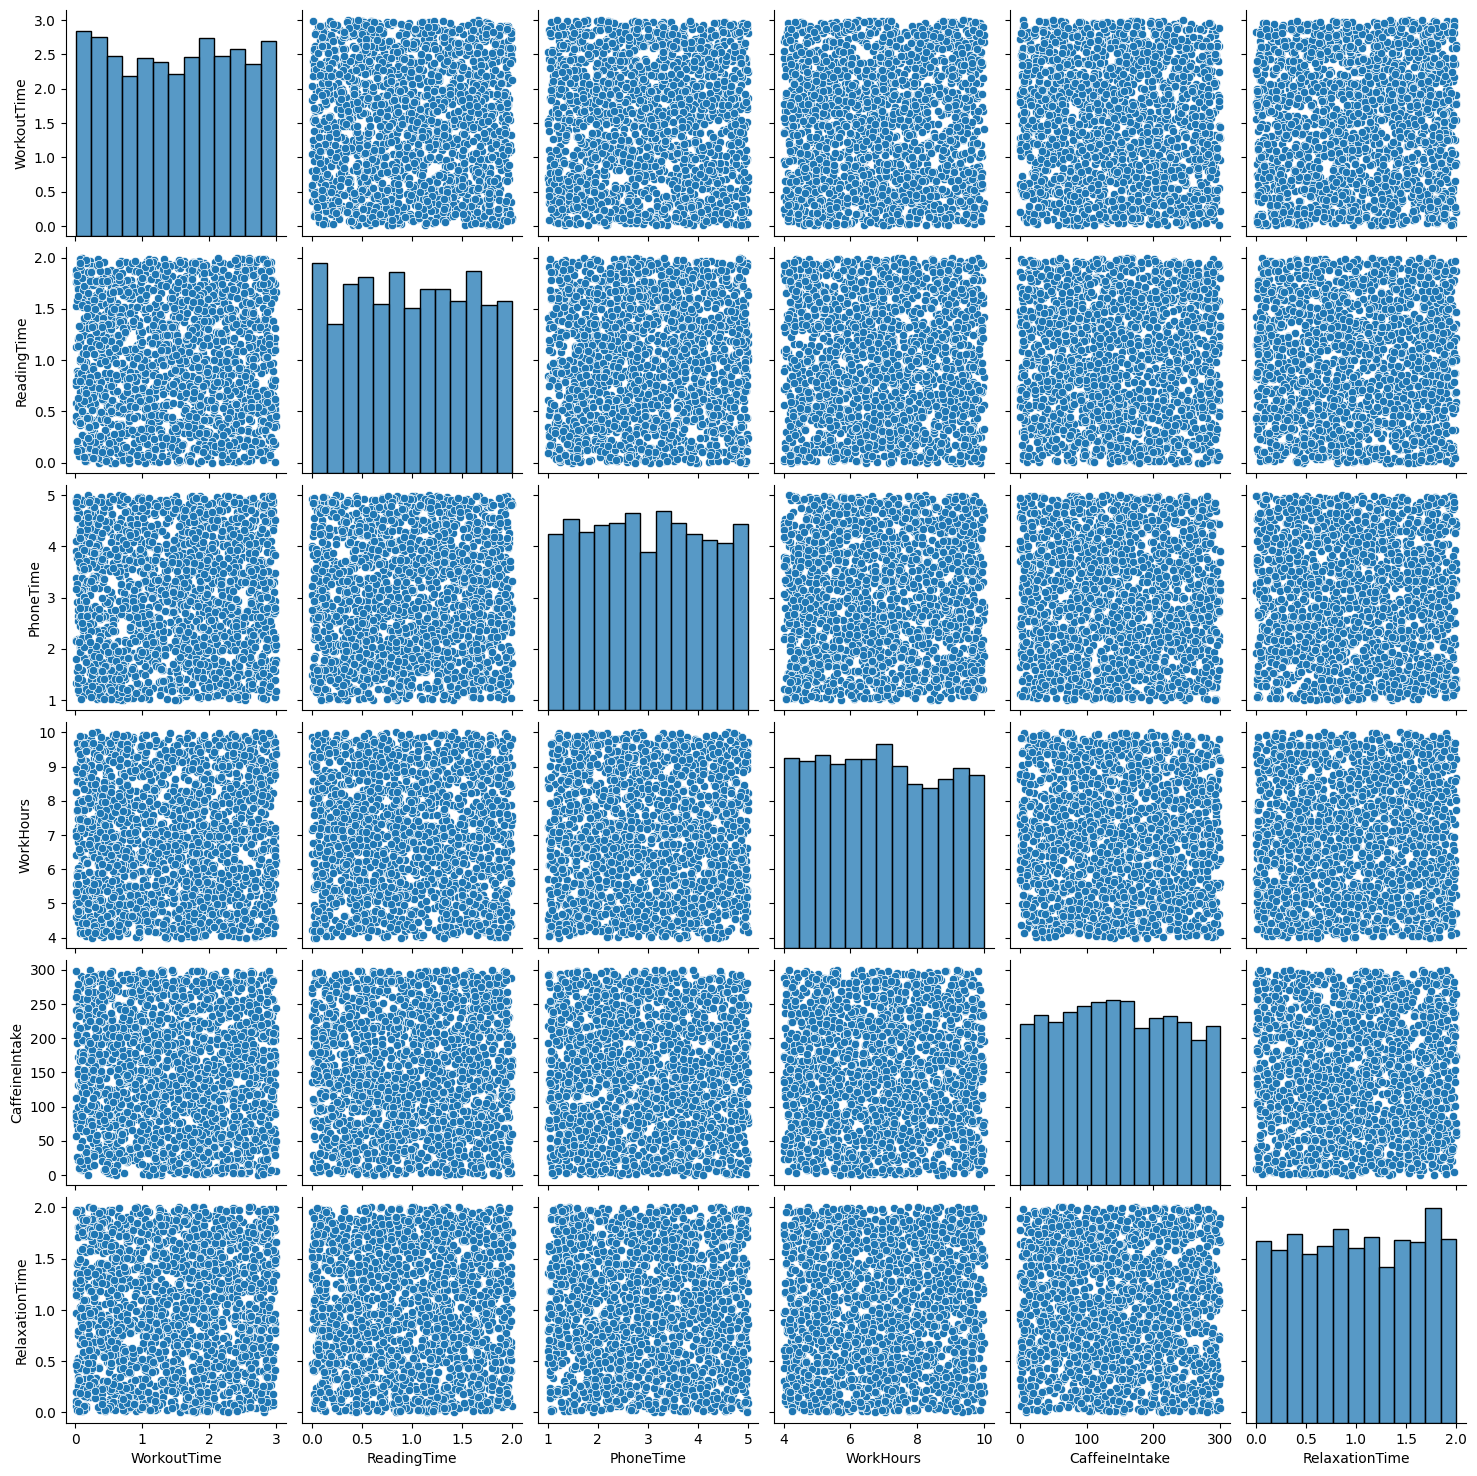

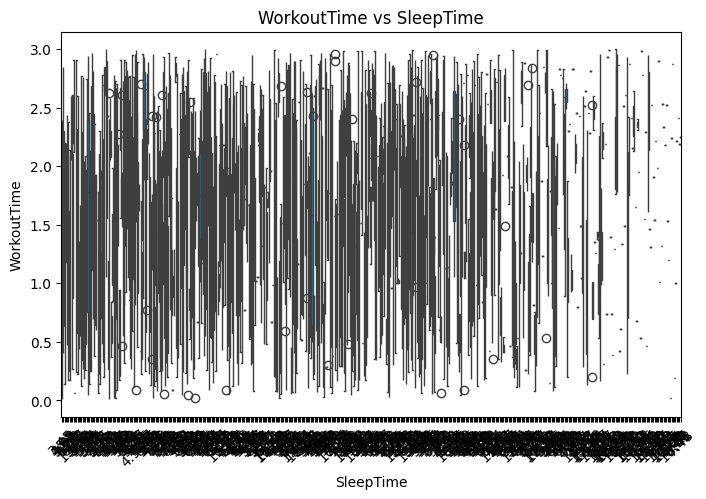

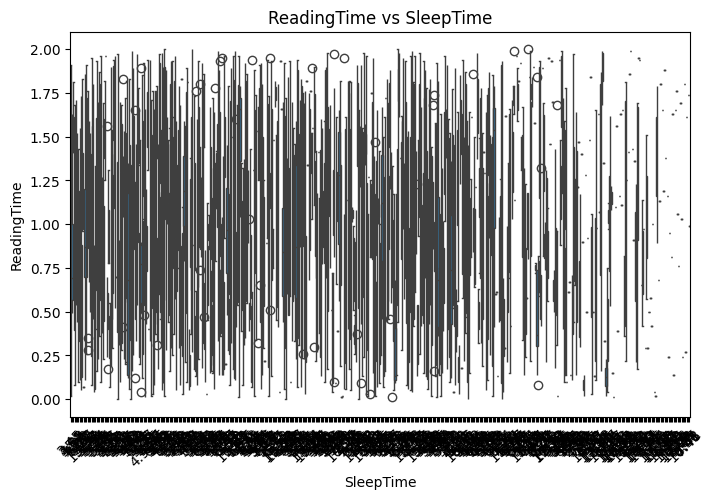

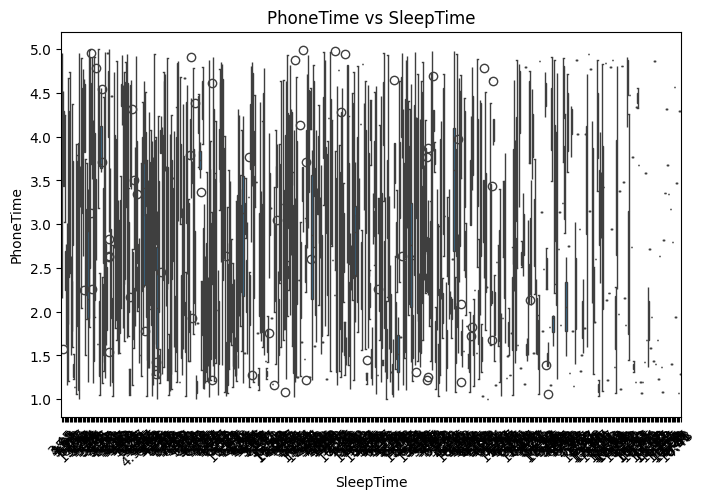

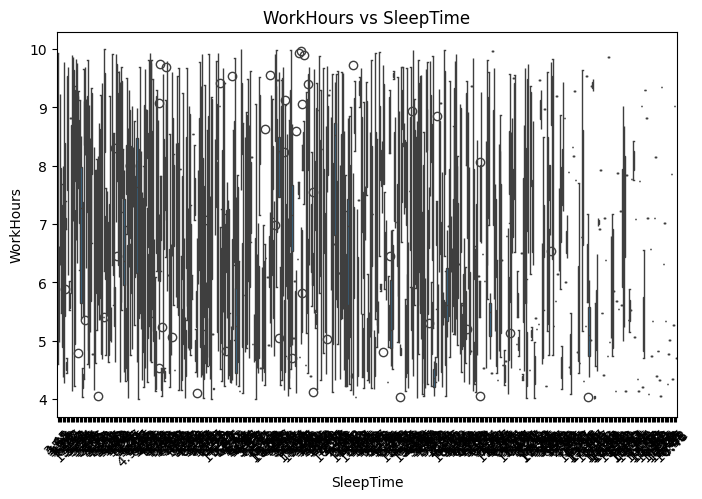

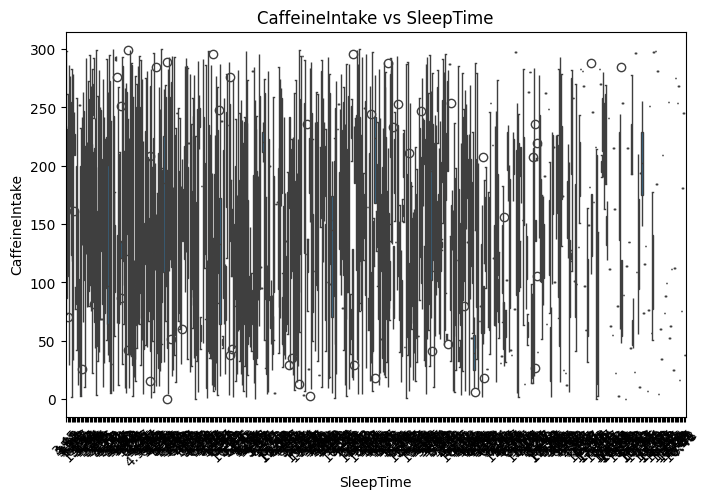

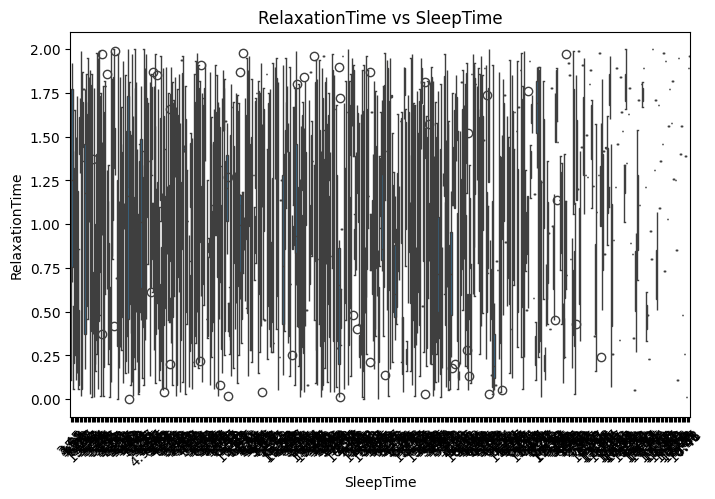

In [34]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

start_time = time()

sleep_ds_path:str = "../data/learning/sleep_time_prediction/sleeptime_prediction_dataset.csv"
sleep_df :pd.DataFrame = load_data_and_inspect(sleep_ds_path)

num_cols, cat_cols = get_numerical_categorical(sleep_df)
sleep_data_univariate(sleep_df, num_cols, cat_cols)
sleep_bivariate(sleep_df, num_cols, cat_cols)